In [1]:
from utils_data import *
from utils_classification import *

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize PopulationData object
population_data = PopulationData()

# Load the data
population_data.load('data/raw/train.csv') \
               .encode_connection_lists() \
			   .encode_connection_int() \
               .encode_population_int() \
               .encode_degrees() \
               .encode_test_train()

# Drop unnecessary columns
population_data.drop_index_patient() \
               .drop_degrees()

In [3]:
# print the data
print(population_data.data.head())

    Population  Infected  Age  Constitution  Behaviour   
id                                                       
0            0         1   49      0.347675          2  \
1            0         1   80      0.324719          1   
2            0         1   71      0.583583          1   
3            0         1   60      0.439978          2   
4            0         1   49      0.553221          1   

                                          Connections      ID  Train   Test  
id                                                                           
0   [277351, 296105, 65366, 77569, 304762, 284344,...  549348  False   True  
1   [549348, 174292, 218499, 210365, 391773, 61034...  277351   True  False  
2   [549348, 629793, 84746, 342699, 645917, 180426...  296105   True  False  
3   [549348, 320126, 581161, 155972, 169602, 40570...   65366   True  False  
4   [277351, 240545, 194781, 402939, 199222, 52310...  174292   True  False  


In [4]:
# Get the dataloader
train_loader, test_loader = population_data.get_dataloaders()

c:\Users\Ryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
# Define model parameters
in_channels = 4  # Number of input features (Age, Constitution, Behaviour, Population)
hidden_channels = 24 # Number of hidden features
out_channels = 2  # Number of output classes (Infected/Not Infected)

In [8]:
# Initialize and train the model
gcn = GraphConvolutionalNetwork(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels)
gcn.fit(train_loader, epochs=100)
gcn.evaluate(test_loader)

Epoch 1/50, Loss: 45.2471
Epoch 2/50, Loss: 37.0451
Epoch 3/50, Loss: 29.4462


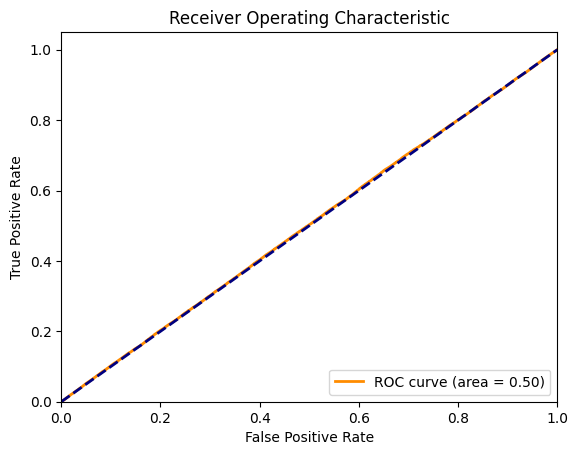

ROC AUC Score: 0.5021


In [7]:
roc_auc = gcn.calculate_roc_auc(test_loader, plot=True)
print(f'ROC AUC Score: {roc_auc:.4f}')